In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import gzip
import networkx as nx
import pandas as pd
from collections import defaultdict

Stage 1


In [ ]:
import pandas as pd
import networkx as nx

# ========== Step 1: Load All Files ==========

base_path = "/content/drive/MyDrive/SNS/data/"

# File mappings
file_paths = {
    "follow": "higgs-social_network.edgelist",
    "retweet": "higgs-retweet_network.edgelist",
    "reply": "higgs-reply_network.edgelist",
    "mention": "higgs-mention_network.edgelist",
}
activity_path = base_path + "higgs-activity_time.txt"

# Read files into DataFrames
network_dfs = {}
for edge_type, filename in file_paths.items():
    path = base_path + filename
    if edge_type == "follow":
        network_dfs[edge_type] = pd.read_csv(path, sep='\s+', header=None, names=["userA", "userB"])
    else:
        network_dfs[edge_type] = pd.read_csv(path, sep='\s+', header=None, names=["userA", "userB", "weight"])

activity_df = pd.read_csv(activity_path, sep='\s+', header=None, names=["userA", "userB", "timestamp", "interaction"])

# ========== Step 2: Create Unified Directed Graph ==========

influence_graph = nx.DiGraph()

# Add edges from all networks
for edge_type, df in network_dfs.items():
    for _, row in df.iterrows():
        u, v = row["userA"], row["userB"]
        weight = row["weight"] if "weight" in row else None

        if influence_graph.has_edge(u, v):
            # Merge multiple edge types
            existing_types = set(influence_graph[u][v].get("edge_type", "").split("+"))
            existing_types.add(edge_type)
            influence_graph[u][v]["edge_type"] = "+".join(sorted(t for t in existing_types if t))
        else:
            influence_graph.add_edge(u, v, edge_type=edge_type)

        # Store per-type weight dictionary
        if weight is not None:
            if "weights" not in influence_graph[u][v]:
                influence_graph[u][v]["weights"] = {}
            influence_graph[u][v]["weights"][edge_type] = weight


# ========== Step 3: Add Timestamps from Activity File ==========

for _, row in activity_df.iterrows():
    u, v, ts, interaction = row["userA"], row["userB"], row["timestamp"], row["interaction"]

    if not influence_graph.has_edge(u, v):
        influence_graph.add_edge(u, v, edge_type=interaction, timestamps=[(ts, interaction)])
    else:
        edge_data = influence_graph[u][v]
        if "timestamps" not in edge_data:
            edge_data["timestamps"] = []
        edge_data["timestamps"].append((ts, interaction))

# ========== Step 4: Summary ==========

print("✅ Unified graph created.")
print(f"Number of nodes: {influence_graph.number_of_nodes()}")
print(f"Number of edges: {influence_graph.number_of_edges()}\n")

print("📌 Sample edges with attributes:")
for u, v, data in list(influence_graph.edges(data=True))[:5]:
    print(f"{u} -> {v} | {data}")

✅ Unified graph created.
Number of nodes: 456626
Number of edges: 15056959

📌 Sample edges with attributes:
1 -> 2 | {'edge_type': 'follow'}
1 -> 3 | {'edge_type': 'follow'}
1 -> 4 | {'edge_type': 'follow'}
1 -> 5 | {'edge_type': 'follow'}
1 -> 6 | {'edge_type': 'follow'}


In [ ]:
# ========== ✅ SAVE THE GRAPH ==========
import pickle

save_path = "/content/drive/MyDrive/SNS/models/influence_graph.pkl"

with open(save_path, "wb") as f:
    pickle.dump(influence_graph, f)

print(f"✅ Graph saved successfully to: {save_path}")

# ========== ✅ SAVE THE GRAPH ==========

✅ Graph saved successfully to: /content/drive/MyDrive/SNS/models/influence_graph.pkl


In [ ]:
import pickle
import networkx as nx  # Make sure NetworkX is available

load_path = "/content/drive/MyDrive/SNS/models/influence_graph.pkl"

with open(load_path, "rb") as f:
    influence_graph = pickle.load(f)

print(f"✅ Graph loaded successfully from: {load_path}")
print(f"📊 Number of nodes: {influence_graph.number_of_nodes()}")
print(f"🔗 Number of edges: {influence_graph.number_of_edges()}")

✅ Graph loaded successfully from: /content/drive/MyDrive/SNS/models/influence_graph.pkl
📊 Number of nodes: 456626
🔗 Number of edges: 15056959


In [ ]:
from google.colab import files

files.download("/content/drive/MyDrive/SNS/models/influence_graph.pkl")
#toufeeq can u see? yes

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Stage 2

In [ ]:
from collections import defaultdict
import pandas as pd

# ========== Stage 2: Feature Engineering ==========

# Step 1: Initialize feature dictionary for each user
user_features = defaultdict(lambda: {
    'num_retweets': 0,
    'num_replies': 0,
    'num_mentions': 0,
    'first_activity_time': float('inf'),
    'last_activity_time': float('-inf'),

    'follower_in_degree': 0,
    'follower_out_degree': 0,

    'retweet_in_degree': 0,
    'retweet_out_degree': 0,

    'reply_in_degree': 0,
    'reply_out_degree': 0,

    'mention_in_degree': 0,
    'mention_out_degree': 0,
})

# Step 2: Count interactions and track activity times
for _, row in activity_df.iterrows():
    userA, userB, timestamp, interaction = row["userA"], row["userB"], row["timestamp"], row["interaction"]

    # Update activity timestamps
    user_features[userA]['first_activity_time'] = min(user_features[userA]['first_activity_time'], timestamp)
    user_features[userA]['last_activity_time'] = max(user_features[userA]['last_activity_time'], timestamp)

    # Count interactions (both users involved)
    if interaction == "RT":
        user_features[userA]['num_retweets'] += 1
        user_features[userB]['num_retweets'] += 1
    elif interaction == "RE":
        user_features[userA]['num_replies'] += 1
        user_features[userB]['num_replies'] += 1
    elif interaction == "MT":
        user_features[userA]['num_mentions'] += 1
        user_features[userB]['num_mentions'] += 1

# Step 3: Add in-degrees and out-degrees from graph structure

# Follower degree from raw graph structure
for user in influence_graph.nodes():
    user_features[user]['follower_in_degree'] = influence_graph.in_degree(user)
    user_features[user]['follower_out_degree'] = influence_graph.out_degree(user)

# Parse multi-type edge labels correctly
for u, v, data in influence_graph.edges(data=True):
    edge_types = data.get('edge_type', '').split('+')  # Handles "retweet+reply"
    for edge_type in edge_types:
        if edge_type == 'retweet':
            user_features[u]['retweet_out_degree'] += 1
            user_features[v]['retweet_in_degree'] += 1
        elif edge_type == 'reply':
            user_features[u]['reply_out_degree'] += 1
            user_features[v]['reply_in_degree'] += 1
        elif edge_type == 'mention':
            user_features[u]['mention_out_degree'] += 1
            user_features[v]['mention_in_degree'] += 1

# Step 4: Time since first exposure
min_ts = activity_df["timestamp"].min()
for user in user_features:
    user_features[user]['time_since_first_exposure'] = user_features[user]['first_activity_time'] - min_ts

# Step 5: Convert to DataFrame
features_df = pd.DataFrame.from_dict(user_features, orient="index")
features_df.index.name = "user_id"
features_df.reset_index(inplace=True)

print("✅ Node features extracted.")
print(features_df.head())


✅ Node features extracted.
   user_id  num_retweets  num_replies  num_mentions  first_activity_time  \
0   223789             3            2             7         1.341101e+09   
1   213163             4            8            21         1.341106e+09   
2   376989             4            0             1         1.341101e+09   
3    50329            28            0            22                  inf   
4    26375             1            0             3         1.341101e+09   

   last_activity_time  follower_in_degree  follower_out_degree  \
0        1.341488e+09                  37                   33   
1        1.341486e+09                  12                   51   
2        1.341607e+09                   1                   23   
3                -inf                 633                   56   
4        1.341490e+09                  57                   90   

   retweet_in_degree  retweet_out_degree  reply_in_degree  reply_out_degree  \
0                  0                   3

In [ ]:
# ========== ✅ SAVE FEATURES ==========
features_save_path = "/content/drive/MyDrive/SNS/models/features.csv"

# Save DataFrame to CSV
features_df.to_csv(features_save_path, index=False)

# ========== ✅ SAVE FEATURES ==========

In [ ]:
features_load_path = "/content/drive/MyDrive/SNS/models/features.csv"

# Step 3: Load the CSV into a DataFrame
features_df = pd.read_csv(features_load_path)

In [ ]:
from google.colab import files

# Download the CSV file to your local machine
files.download("/content/drive/MyDrive/SNS/models/features.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Adding Node feature to the graph

In [ ]:
# Step 1: Add node features to influence_graph
for _, row in features_df.iterrows():
    user = int(row["user_id"])
    features = row.drop("user_id")
    if not influence_graph.has_node(user):
        influence_graph.add_node(user)
    influence_graph.nodes[user].update(features.to_dict())

# Step 2: Add missing self-loops only
for node in influence_graph.nodes:
    if not influence_graph.has_edge(node, node):
        influence_graph.add_edge(node, node, edge_type="self_loop", is_synthetic=True)


print("✅ Final influence_graph with features")
print(f"Number of nodes: {influence_graph.number_of_nodes()}")
print(f"Number of edges: {influence_graph.number_of_edges()}")



✅ Final influence_graph with features
Number of nodes: 456626
Number of edges: 15508209


#Stage 3#

#  ( Influential Score for Rule Based prediction + for the model)

In [ ]:
from collections import defaultdict
from tqdm import tqdm

def compute_time_respecting_influence(graph, follow_weight=0.2, damping=0.5):
    influence_scores = defaultdict(float)

    # Store tweet times for each node
    node_timestamps = defaultdict(list)

    print("Recording timestamps from interactions...")
    # First pass: record all user timestamps from interactions
    for u, v, data in tqdm(graph.edges(data=True), desc="Collecting timestamps"):
        if data.get("edge_type") != "follow":
            timestamps = data.get("timestamps", [])
            for ts, _ in timestamps:
                node_timestamps[u].append(ts)

    # Sort timestamps for each node
    for node in node_timestamps:
        node_timestamps[node] = sorted(node_timestamps[node])

    print("Computing 1-hop time-respecting influence...")
    # 1-hop influence (time-aware)
    for u, v, data in tqdm(graph.edges(data=True), desc="1-hop influence"):
        edge_type = data.get("edge_type")
        if edge_type == "follow":
            influence_scores[u] += follow_weight
        else:
            timestamps = data.get("timestamps", [])
            for ts, _ in timestamps:
                if ts in node_timestamps[u] and (
                    not node_timestamps[v] or ts < min(node_timestamps[v])
                ):
                    influence_scores[u] += data.get("weight", 1.0)

    print("Computing 2-hop time-respecting influence with damping...")
    # 2-hop influence with damping (time-aware)
    for u in tqdm(graph.nodes(), desc="2-hop influence"):
        for v in graph.successors(u):
            edge_data_uv = graph.get_edge_data(u, v)
            ts_uv_valid = []

            # Collect valid (u→v) time-respecting timestamps
            if edge_data_uv and edge_data_uv.get("edge_type") != "follow":
                for ts, _ in edge_data_uv.get("timestamps", []):
                    if ts in node_timestamps[u] and (
                        not node_timestamps[v] or ts < min(node_timestamps[v])
                    ):
                        ts_uv_valid.append(ts)

            weight_uv = len(ts_uv_valid) * edge_data_uv.get("weight", 1.0) if ts_uv_valid else 0

            # Now find v→w 2-hop edges
            for w in graph.successors(v):
                if w == u:
                    continue  # avoid cycles
                edge_data_vw = graph.get_edge_data(v, w)
                ts_vw_valid = []

                if edge_data_vw and edge_data_vw.get("edge_type") != "follow":
                    for ts, _ in edge_data_vw.get("timestamps", []):
                        if ts in node_timestamps[v] and (
                            not node_timestamps[w] or ts < min(node_timestamps[w])
                        ):
                            ts_vw_valid.append(ts)

                weight_vw = len(ts_vw_valid) * edge_data_vw.get("weight", 1.0) if ts_vw_valid else 0

                # Add damped 2-hop score
                influence_scores[u] += damping * weight_uv * weight_vw

    print("Assigning influence scores to graph nodes...")
    for node in tqdm(graph.nodes(), desc="Assigning influence scores"):
        graph.nodes[node]["influence_score"] = round(influence_scores.get(node, 0.0), 3)

    return dict(influence_scores)

In [ ]:
influence_scores = compute_time_respecting_influence(influence_graph)

Recording timestamps from interactions...


Computing 1-hop time-respecting influence...


1-hop influence: 100%|██████████| 15508209/15508209 [00:07<00:00, 2075382.19it/s]


Computing 2-hop time-respecting influence with damping...


2-hop influence: 100%|██████████| 456626/456626 [13:40<00:00, 556.31it/s] 


Assigning influence scores to graph nodes...


Assigning influence scores: 100%|██████████| 456626/456626 [00:00<00:00, 771326.45it/s]


In [ ]:
# ========== ✅ SAVE THE INFLUENCE_GRAPH ==========
import pickle

graph_save_path = "/content/drive/MyDrive/SNS/models/prefinal_influence_graph.pkl"

with open(graph_save_path, 'wb') as f:
    pickle.dump(influence_graph, f)

print(f"✅ Influence graph with scores and labels saved to: {graph_save_path}")
# ========== ✅ SAVE THE  INFLUENCE_GRAPh ==========

✅ Influence graph with scores and labels saved to: /content/drive/MyDrive/SNS/models/final_influence_graph.pkl


In [ ]:
# Path to the saved influence graph
graph_load_path = "/content/drive/MyDrive/SNS/models/prefinal_influence_graph.pkl"

# Load the graph
with open(graph_load_path, 'rb') as f:
    final_influence_graph = pickle.load(f)

print("✅ Influence graph loaded successfully!")

✅ Influence graph loaded successfully!


In [ ]:
from google.colab import files

# Download the pickle file to your local machine
files.download("/content/drive/MyDrive/SNS/models/prefinal_influence_graph.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Stage 4 Preprocessing Stage

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# -------- Node Features Preprocessing --------
node_features = []
for node, attrs in final_influence_graph.nodes(data=True):
    row = {"user_id": node}
    row.update(attrs)
    node_features.append(row)

features_df = pd.DataFrame(node_features)

features_df.replace([np.inf, -np.inf], np.nan, inplace=True)
features_df.fillna(features_df.median(), inplace=True)

numeric_cols = features_df.columns.difference(['user_id'])
scaler = StandardScaler()
features_df[numeric_cols] = scaler.fit_transform(features_df[numeric_cols])

for _, row in features_df.iterrows():
    user = int(row["user_id"])
    features = row.drop("user_id").to_dict()
    if not final_influence_graph.has_node(user):
        final_influence_graph.add_node(user)
    final_influence_graph.nodes[user].update(features)

# -------- Edge Features Preprocessing --------

edge_data_list = []


possible_edge_types = ['follow', 'mention', 'reply', 'retweet', 'self_loop']
mlb = MultiLabelBinarizer(classes=possible_edge_types)


all_edge_type_sets = []
for _, _, edge_attrs in final_influence_graph.edges(data=True):
    edge_type_str = edge_attrs.get('edge_type', '')
    edge_type_set = edge_type_str.split('+') if edge_type_str else []
    all_edge_type_sets.append(edge_type_set)

mlb.fit(all_edge_type_sets)  # Fit once here

for u, v, edge_attrs in final_influence_graph.edges(data=True):

    edge_type_str = edge_attrs.get('edge_type', '')
    edge_type_set = edge_type_str.split('+') if edge_type_str else []

    # Multi-hot encode edge_type using transform only
    edge_type_encoded = mlb.transform([edge_type_set])[0]  # e.g. [1,1,0,1,0]

    # Extract weights for known types (default 0 if missing)
    weights = edge_attrs.get('weights', {})
    weight_retweet = weights.get('retweet', 0)
    weight_reply = weights.get('reply', 0)
    weight_mention = weights.get('mention', 0)
    weight_follow = 1 if 'follow' in edge_type_set else 0  # fallback binary indicator

    # Timestamps: Optional feature, e.g. total events or recency (latest timestamp)
    timestamps = edge_attrs.get('timestamps', [])
    timestamp_count = len(timestamps)
    latest_timestamp = max([t[0] for t in timestamps], default=0)

    # Combine features into a vector
    edge_feature_vector = np.array([
        *edge_type_encoded,
        weight_retweet,
        weight_reply,
        weight_mention,
        weight_follow,
        timestamp_count,
        latest_timestamp
    ], dtype=np.float32)

    edge_data_list.append(((u, v), edge_feature_vector))

# Create dataframe for edges
edges_df = pd.DataFrame([
    {
        'source': uv[0],
        'target': uv[1],
        **{f'feat_{i}': vec[i] for i in range(len(vec))}
    }
    for uv, vec in edge_data_list
])

# Normalize edge features (excluding source and target)
edge_feature_cols = edges_df.columns.difference(['source', 'target'])
edges_df[edge_feature_cols] = StandardScaler().fit_transform(edges_df[edge_feature_cols])

# Update graph edges with processed features
for _, row in edges_df.iterrows():
    u = int(row['source'])
    v = int(row['target'])
    features = row[edge_feature_cols].to_dict()
    if final_influence_graph.has_edge(u, v):
        final_influence_graph.edges[u, v].update(features)

# -------- Self-loops (if needed) --------
for node in final_influence_graph.nodes:
    if not final_influence_graph.has_edge(node, node):
        final_influence_graph.add_edge(node, node, edge_type="self_loop", is_synthetic=True)

print("✅ Node and edge features cleaned and final influence graph updated in-place.")


✅ Node and edge features cleaned and final influence graph updated in-place.


In [ ]:
import pickle

save_path = "/content/drive/MyDrive/SNS/models/final_influence_graph.pkl"

with open(save_path, "wb") as f:
    pickle.dump(final_influence_graph, f)

print(f"✅ Final influence graph saved to: {save_path}")


✅ Final influence graph saved to: /content/drive/MyDrive/SNS/models/final_influence_graph.pkl


In [ ]:
import pickle
import networkx as nx  # Make sure NetworkX is imported

load_path = "/content/drive/MyDrive/SNS/models/final_influence_graph.pkl"

with open(load_path, "rb") as f:
    final_influence_graph = pickle.load(f)

print(f"✅ Final influence graph loaded from: {load_path}")
print(f"📊 Number of nodes: {final_influence_graph.number_of_nodes()}")
print(f"🔗 Number of edges: {final_influence_graph.number_of_edges()}")


✅ Final influence graph loaded from: /content/drive/MyDrive/SNS/models/final_influence_graph.pkl
📊 Number of nodes: 456626
🔗 Number of edges: 15508209


# For Visualization

In [ ]:
# Show a few nodes and their attributes
print("📌 Sample nodes with features:")
for node, data in list(final_influence_graph.nodes(data=True))[:5]:  # first 5 nodes
    print(f"User {node} -> {data}")


📌 Sample nodes with features:
User 1 -> {'num_retweets': -0.04220282073206717, 'num_replies': -0.05320012914591608, 'num_mentions': -0.028789959767869633, 'first_activity_time': -0.12443819580434229, 'last_activity_time': -0.2143717749391989, 'follower_in_degree': 45.71020800453062, 'follower_out_degree': -0.22281357976288657, 'retweet_in_degree': -0.0246269260438008, 'retweet_out_degree': -0.5944333502446945, 'reply_in_degree': -0.027290551555087524, 'reply_out_degree': -0.20245574054551993, 'mention_in_degree': -0.016175771316372285, 'mention_out_degree': -0.3552926759820181, 'time_since_first_exposure': -0.1244381958026153}
User 2 -> {'num_retweets': -0.015055347681605245, 'num_replies': 0.27594953986095444, 'num_mentions': 0.047982257503883775, 'first_activity_time': 4.002910397779825, 'last_activity_time': 3.6808911878020534, 'follower_in_degree': 13.150141344207015, 'follower_out_degree': 0.8938551959192882, 'retweet_in_degree': -0.0246269260438008, 'retweet_out_degree': 0.232775

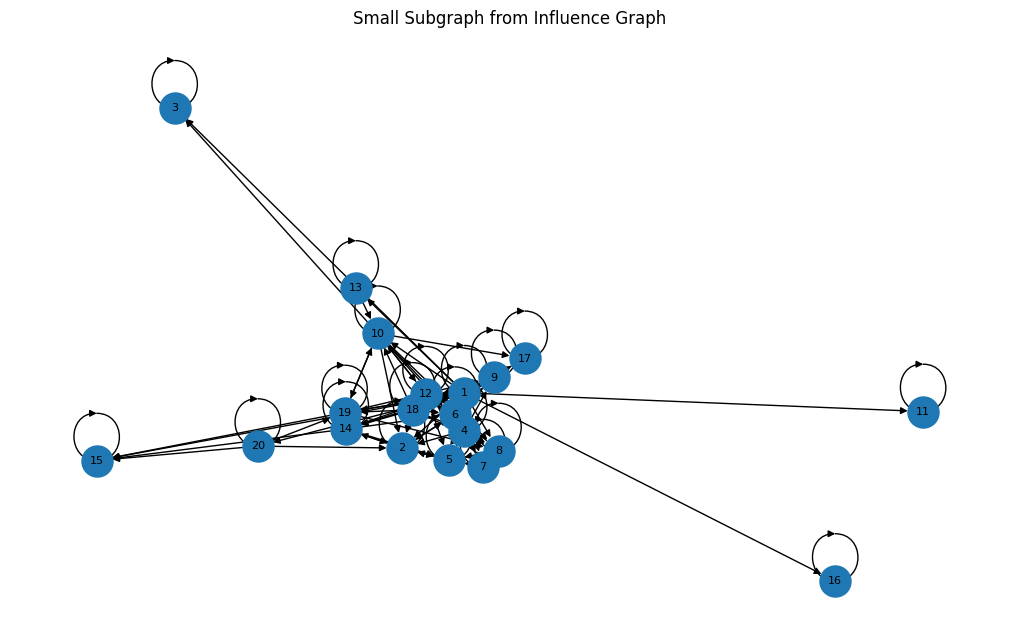

In [ ]:
import matplotlib.pyplot as plt

# Draw a subgraph of the first 20 nodes
sub_nodes = list(influence_graph.nodes)[:20]
subgraph = final_influence_graph.subgraph(sub_nodes)

plt.figure(figsize=(10, 6))
nx.draw(subgraph, with_labels=True, node_size=500, font_size=8, arrows=True)
plt.title("Small Subgraph from Influence Graph")
plt.show()

In [ ]:
final_influence_graph.edges[46378,88]

{'edge_type': 'follow+mention+reply+retweet',
 'weights': {'retweet': np.int64(4),
  'reply': np.int64(1),
  'mention': np.int64(4)},
 'timestamps': [(1341379964, 'RT'),
  (1341380583, 'RT'),
  (1341381452, 'MT'),
  (1341381452, 'RE'),
  (1341381528, 'MT'),
  (1341382869, 'RT'),
  (1341384828, 'RT'),
  (1341398113, 'MT'),
  (1341563320, 'MT')]}

In [ ]:
for u, v, edge_data in list(final_influence_graph.edges(data=True))[:5]:
    u_features = final_influence_graph.nodes[u]
    v_features = final_influence_graph.nodes[v]
    print(f"Edge: {u} -> {v} | edge_data: {edge_data}")
    print(f"  Node {u} features: {u_features}")
    print(f"  Node {v} features: {v_features}\n")

Edge: 1 -> 2 | edge_data: {'edge_type': 'follow'}
  Node 1 features: {'num_retweets': 0.0, 'num_replies': 0.0, 'num_mentions': 0.0, 'first_activity_time': inf, 'last_activity_time': -inf, 'follower_in_degree': 16280.0, 'follower_out_degree': 22.0, 'retweet_in_degree': 0.0, 'retweet_out_degree': 0.0, 'reply_in_degree': 0.0, 'reply_out_degree': 0.0, 'mention_in_degree': 0.0, 'mention_out_degree': 0.0, 'time_since_first_exposure': inf}
  Node 2 features: {'num_retweets': 1.0, 'num_replies': 1.0, 'num_mentions': 2.0, 'first_activity_time': 1341674210.0, 'last_activity_time': 1341674210.0, 'follower_in_degree': 4707.0, 'follower_out_degree': 77.0, 'retweet_in_degree': 0.0, 'retweet_out_degree': 1.0, 'reply_in_degree': 1.0, 'reply_out_degree': 0.0, 'mention_in_degree': 2.0, 'mention_out_degree': 0.0, 'time_since_first_exposure': 573238.0}

Edge: 1 -> 3 | edge_data: {'edge_type': 'follow'}
  Node 1 features: {'num_retweets': 0.0, 'num_replies': 0.0, 'num_mentions': 0.0, 'first_activity_time':

In [ ]:
# Number of nodes
print(f"Total nodes: {final_influence_graph.number_of_nodes()}")

# Sample node attributes (first 5 nodes)
for i, (node, attrs) in enumerate(final_influence_graph.nodes(data=True)):
    print(f"Node {node}: {attrs}")
    if i >= 4:
        break


# Stage 5  


In [ ]:
!pip install torch-scatter torch-sparse torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00


In [ ]:
import torch
from torch_geometric.data import Data
import random
import numpy as np

def nx_to_pyg_data_with_edge_attrs(graph, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    node_list = list(graph.nodes())
    node_to_idx = {node: i for i, node in enumerate(node_list)}

    exclude_keys = ['user_id', 'is_influential', 'influence_score']
    feature_keys = [k for k in graph.nodes[node_list[0]].keys() if k not in exclude_keys]

    features = []
    for node in node_list:
        attrs = graph.nodes[node]
        feat_vector = [attrs.get(k, 0.0) for k in feature_keys]
        features.append(feat_vector)
    x = torch.tensor(features, dtype=torch.float)

    # Prepare edge index and edge features
    edge_indices = []
    edge_features = []
    edge_feature_keys = None

    for u, v, attrs in graph.edges(data=True):
        edge_indices.append((node_to_idx[u], node_to_idx[v]))

        # Collect edge features (all except 'edge_type' string, adjust if needed)
        if edge_feature_keys is None:
            edge_feature_keys = [k for k in attrs.keys() if k != 'edge_type']
        feat_vec = [attrs.get(k, 0.0) for k in edge_feature_keys]
        edge_features.append(feat_vec)

    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float) if edge_features else None

    y = torch.tensor([graph.nodes[node].get("influence_score", 0.0) for node in node_list], dtype=torch.float)

    # Train/val/test splits for nodes
    num_nodes = len(node_list)
    indices = list(range(num_nodes))
    random.shuffle(indices)

    train_cut = int(train_ratio * num_nodes)
    val_cut = int((train_ratio + val_ratio) * num_nodes)

    train_idx = indices[:train_cut]
    val_idx = indices[train_cut:val_cut]
    test_idx = indices[val_cut:]

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True

    data = Data(x=x, edge_index=edge_index, y=y,
                train_mask=train_mask, val_mask=val_mask, test_mask=test_mask,
                edge_attr=edge_attr)

    return data, node_to_idx, feature_keys, edge_feature_keys

# Usage:
pyg_data, node_map, node_feature_keys, edge_feature_keys = nx_to_pyg_data_with_edge_attrs(final_influence_graph)

print(pyg_data)
print(f"Node features used: {node_feature_keys}")
print(f"Edge features used: {edge_feature_keys}")


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


Data(x=[456626, 14], edge_index=[2, 15508209], edge_attr=[15508209, 11], y=[456626], train_mask=[456626], val_mask=[456626], test_mask=[456626])
Node features used: ['num_retweets', 'num_replies', 'num_mentions', 'first_activity_time', 'last_activity_time', 'follower_in_degree', 'follower_out_degree', 'retweet_in_degree', 'retweet_out_degree', 'reply_in_degree', 'reply_out_degree', 'mention_in_degree', 'mention_out_degree', 'time_since_first_exposure']
Edge features used: ['feat_0', 'feat_1', 'feat_10', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7', 'feat_8', 'feat_9']


In [ ]:
# ========== ✅ SAVEs THE SPLITS ==========
import torch

data_save_path = "/content/drive/MyDrive/SNS/models/pyg_data_regressor.pt"
torch.save(pyg_data, data_save_path)
print(f"✅ PyG data saved to: {data_save_path}")
# ========== ✅ SAVEs THE SPLITS ==========

✅ PyG data saved to: /content/drive/MyDrive/SNS/models/pyg_data_regressor.pt


In [ ]:
import torch

data_load_path = "/content/drive/MyDrive/SNS/models/pyg_data_regressor.pt"

pyg_data = torch.load(data_load_path, weights_only=False)

print(f"✅ PyG data loaded from: {data_load_path}")
print(pyg_data)


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


✅ PyG data loaded from: /content/drive/MyDrive/SNS/models/pyg_data_regressor.pt
Data(x=[456626, 14], edge_index=[2, 15508209], edge_attr=[15508209, 11], y=[456626], train_mask=[456626], val_mask=[456626], test_mask=[456626])


# Stage 6 Training The Models



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,GATConv, SAGEConv, TransformerConv
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Model 1: GCN

In [ ]:
class GCNRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GCNRegressor, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index):
        x = self.gcn1(x, edge_index)
        x = F.relu(x)
        x = self.gcn2(x, edge_index)
        x = F.relu(x)
        out = self.linear(x)
        return out.view(-1)


criterion = nn.MSELoss()
model = GCNRegressor(input_dim=pyg_data.num_features, hidden_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        loss = criterion(out[mask], data.y[mask])
        rmse = torch.sqrt(loss)
    return rmse.item()

for epoch in range(1, 501):
    loss = train(model, pyg_data, optimizer, criterion)
    val_rmse = evaluate(model, pyg_data, pyg_data.val_mask)
    print(f"[GCN] Epoch {epoch:03d} | Loss: {loss:.4f} | Val RMSE: {val_rmse:.4f}")


[GCN] Epoch 001 | Loss: 0.9824 | Val RMSE: 0.9529
[GCN] Epoch 002 | Loss: 0.8799 | Val RMSE: 0.9081
[GCN] Epoch 003 | Loss: 0.7968 | Val RMSE: 0.8694
[GCN] Epoch 004 | Loss: 0.7271 | Val RMSE: 0.8357
[GCN] Epoch 005 | Loss: 0.6676 | Val RMSE: 0.8062
[GCN] Epoch 006 | Loss: 0.6165 | Val RMSE: 0.7831
[GCN] Epoch 007 | Loss: 0.5760 | Val RMSE: 0.7700
[GCN] Epoch 008 | Loss: 0.5500 | Val RMSE: 0.7687
[GCN] Epoch 009 | Loss: 0.5393 | Val RMSE: 0.7726
[GCN] Epoch 010 | Loss: 0.5372 | Val RMSE: 0.7739
[GCN] Epoch 011 | Loss: 0.5355 | Val RMSE: 0.7700
[GCN] Epoch 012 | Loss: 0.5301 | Val RMSE: 0.7617
[GCN] Epoch 013 | Loss: 0.5205 | Val RMSE: 0.7521
[GCN] Epoch 014 | Loss: 0.5103 | Val RMSE: 0.7432
[GCN] Epoch 015 | Loss: 0.5025 | Val RMSE: 0.7348
[GCN] Epoch 016 | Loss: 0.4961 | Val RMSE: 0.7277
[GCN] Epoch 017 | Loss: 0.4914 | Val RMSE: 0.7226
[GCN] Epoch 018 | Loss: 0.4880 | Val RMSE: 0.7184
[GCN] Epoch 019 | Loss: 0.4845 | Val RMSE: 0.7150
[GCN] Epoch 020 | Loss: 0.4812 | Val RMSE: 0.7121


In [ ]:
test_rmse = evaluate(model, pyg_data, pyg_data.test_mask)
print(f"[GCN] Test RMSE: {test_rmse:.4f}")

In [ ]:
# ========== ✅ SAVES GCN MODEL ==========
import torch

model_save_path = "/content/drive/MyDrive/SNS/models/gcn_model_regressor.pth"

torch.save(model.state_dict(), model_save_path)

print(f"✅ GAT model saved to: {model_save_path}")

# ========== ✅ SAVES GCN MODEL ==========

# MODEL 2: GAT (IGNORE FOR NOW)

In [ ]:
class GATRegressor(nn.Module):
    def init(self, input_dim, hidden_dim, output_dim, num_heads=4):
        super(GATRegressor, self).init()
        # First GAT layer with multiple heads
        self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, dropout=0.2)
        # Second GAT layer with one head and no concatenation
        self.gat2 = GATConv(hidden_dim * num_heads, output_dim, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x.squeeze()  # Shape: [num_nodes]

# Define loss function for regression
criterion = nn.MSELoss()

# Training function
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation function (returns MSE)
def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        mse = criterion(out[mask], data.y[mask])
    return mse.item()

# Hyperparameters
input_dim = pyg_data.num_node_features
hidden_dim = 64
output_dim = 1
num_heads = 4

# Initialize model and optimizer
model = GATRegressor(input_dim, hidden_dim, output_dim, num_heads)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# Training loop
for epoch in range(1, 1001):
    loss = train(model, pyg_data, optimizer, criterion)
    val_mse = evaluate(model, pyg_data, pyg_data.val_mask)
    print(f"[GAT] Epoch {epoch:03d} | Train Loss: {loss:.4f} | Val MSE: {val_mse:.4f}")

In [ ]:
test_mse = evaluate(model, pyg_data, pyg_data.test_mask)
print(f"[GAT] Test MSE: {test_mse:.4f}")

In [ ]:
# ========== ✅ SAVES GAT MODEL ==========
import torch

model_save_path = "/content/drive/MyDrive/SNS/models/gat_model_regressor.pth"

torch.save(model.state_dict(), model_save_path)

print(f"✅ SAGE model saved to: {model_save_path}")

# ========== ✅ SAVES GAT MODEL ==========

# MODEL 3: Graphomer


In [ ]:
# --- Define Graphormer Regressor ---
class GraphormerRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, edge_dim):
        super(GraphormerRegressor, self).__init__()
        self.conv1 = TransformerConv(input_dim, hidden_dim, heads=4, edge_dim=edge_dim)
        self.conv2 = TransformerConv(hidden_dim * 4, hidden_dim, heads=1, edge_dim=edge_dim)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        return self.linear(x).squeeze()

# --- Training & Evaluation ---
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    mse = F.mse_loss(out[mask], data.y[mask]).item()
    rmse = mse ** 0.5
    mae = F.l1_loss(out[mask], data.y[mask]).item()
    return rmse, mae

# --- Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = pyg_data.num_node_features
hidden_dim = 64
edge_dim = pyg_data.edge_attr.shape[1]

model = GraphormerRegressor(input_dim, hidden_dim, edge_dim).to(device)
pyg_data = pyg_data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

# --- Checkpoint Path ---
checkpoint_dir = "/content/drive/MyDrive/SNS/checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, 'graphormer_regression.pt')

# --- Resume from Checkpoint if exists ---
best_val_rmse = float('inf')
start_epoch = 1

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_val_rmse = checkpoint['best_val_rmse']
    start_epoch = checkpoint['epoch'] + 1
    print(f"🔄 Resumed from epoch {start_epoch}, best_val_rmse = {best_val_rmse:.4f}")

# --- Training Loop ---
for epoch in range(start_epoch, 1001):
    loss = train(model, pyg_data, optimizer, criterion)
    val_rmse, val_mae = evaluate(model, pyg_data, pyg_data.val_mask)
    print(f"[Epoch {epoch:03d}] Loss: {loss:.4f} | Val RMSE: {val_rmse:.4f} | Val MAE: {val_mae:.4f}")

    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_rmse': best_val_rmse
        }, checkpoint_path)
        print("  ✅ Checkpoint saved (val RMSE improved)")


[Epoch 001] Loss: 2.1878 | Val MSE: 13.0101 | Val MAE: 1.9700
  ✅ Checkpoint saved (val MSE improved)
[Epoch 002] Loss: 10.1678 | Val MSE: 2.1033 | Val MAE: 0.8616
  ✅ Checkpoint saved (val MSE improved)
[Epoch 003] Loss: 1.7701 | Val MSE: 0.8888 | Val MAE: 0.5232
  ✅ Checkpoint saved (val MSE improved)
[Epoch 004] Loss: 0.8154 | Val MSE: 1.5949 | Val MAE: 0.7831
[Epoch 005] Loss: 1.3089 | Val MSE: 1.8538 | Val MAE: 0.8425
[Epoch 006] Loss: 1.3757 | Val MSE: 1.6260 | Val MAE: 0.8094
[Epoch 007] Loss: 1.2031 | Val MSE: 1.2730 | Val MAE: 0.7391
[Epoch 008] Loss: 0.9743 | Val MSE: 0.9635 | Val MAE: 0.6603
[Epoch 009] Loss: 0.7669 | Val MSE: 0.7218 | Val MAE: 0.5857
  ✅ Checkpoint saved (val MSE improved)
[Epoch 010] Loss: 0.6054 | Val MSE: 0.5757 | Val MAE: 0.5231
  ✅ Checkpoint saved (val MSE improved)


In [ ]:
# --- Evaluate Graphormer on Test Mask ---
test_rmse, test_mae = evaluate(model, pyg_data, pyg_data.test_mask)
print(f"[Graphormer] Test RMSE: {test_rmse:.4f} | Test MAE: {test_mae:.4f}")


In [ ]:
# ========== ✅ SAVES GRAPHORMER MODEL ==========
final_model_path = "/content/drive/MyDrive/SNS/models/graphormer_regressor.pth"
torch.save(model.state_dict(), final_model_path)
print(f"✅ Final Graphormer model saved to: {final_model_path}")

# ========== ✅ SAVES GRAPHORMER MODEL ==========

NameError: name 'model' is not defined

# MODEL 4: Sage


In [ ]:
class GraphSAGERegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GraphSAGERegressor, self).__init__()
        self.sage1 = SAGEConv(input_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index):
        x = self.sage1(x, edge_index)
        x = F.relu(x)
        x = self.sage2(x, edge_index)
        x = F.relu(x)
        out = self.linear(x)
        return out.view(-1)

criterion = nn.MSELoss()


def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        loss = criterion(out[mask], data.y[mask])
        rmse = torch.sqrt(loss)
    return rmse.item()

model = GraphSAGERegressor(input_dim=pyg_data.num_features, hidden_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(1, 501):
    loss = train(model, pyg_data, optimizer, criterion)
    val_rmse = evaluate(model, pyg_data, pyg_data.val_mask)
    print(f"[GraphSAGE] Epoch {epoch:03d} | Loss: {loss:.4f} | Val RMSE: {val_rmse:.4f}")

[GraphSAGE] Epoch 001 | Loss: 1.0977 | Val RMSE: 0.9576
[GraphSAGE] Epoch 002 | Loss: 0.8863 | Val RMSE: 0.8998
[GraphSAGE] Epoch 003 | Loss: 0.7518 | Val RMSE: 0.8556
[GraphSAGE] Epoch 004 | Loss: 0.6332 | Val RMSE: 0.8227
[GraphSAGE] Epoch 005 | Loss: 0.5416 | Val RMSE: 0.8110
[GraphSAGE] Epoch 006 | Loss: 0.4891 | Val RMSE: 0.7968
[GraphSAGE] Epoch 007 | Loss: 0.4349 | Val RMSE: 0.7719
[GraphSAGE] Epoch 008 | Loss: 0.3757 | Val RMSE: 0.7307
[GraphSAGE] Epoch 009 | Loss: 0.3206 | Val RMSE: 0.6438
[GraphSAGE] Epoch 010 | Loss: 0.2506 | Val RMSE: 0.5382
[GraphSAGE] Epoch 011 | Loss: 0.1938 | Val RMSE: 0.4406


In [ ]:
test_rmse = evaluate(model, pyg_data, pyg_data.test_mask)
print(f"[GraphSAGE] Test RMSE: {test_rmse:.4f}")


In [ ]:
# ========== ✅ SAVES SAGE MODEL ==========
import torch

model_save_path = "/content/drive/MyDrive/SNS/models/sage_model_regressor.pth"

torch.save(model.state_dict(), model_save_path)

print(f"✅ SAGE model saved to: {model_save_path}")

# ========== ✅ SAVES SAGE MODEL ==========

# Stage 7  


# 1 Run inference on all nodes using all four of your trained models

In [ ]:
import torch

pyg_data = torch.load("/content/drive/MyDrive/SNS/models/pyg_data.pt", weights_only=False)


1. GCN Inference

In [ ]:
@torch.no_grad()
def get_influence_scores(model, data):
    model.eval()
    scores = model(data.x, data.edge_index)  # For GCN
    return scores.view(-1)

# Load trained GCN model
gcn_model = GCN(input_dim=pyg_data.num_features, hidden_dim=64)
gcn_model.load_state_dict(torch.load("/content/drive/MyDrive/SNS/models/gcn_model_regressor.pth"))

# Run inference
gcn_scores = get_influence_scores(gcn_model, pyg_data)
print("Sample influence scores:", gcn_scores[:5])

# Save raw scores only
torch.save(gcn_scores, "/content/drive/MyDrive/SNS/preds/gcn_preds_regressor.pt")


tensor([[ 33.8278, -29.7796],
        [-21.4705,  10.4540],
        [ -2.2181,   0.9723],
        [-29.0152,  13.8864],
        [-14.4155,   6.9120]])
tensor([0, 1, 1, 1, 1])
96700
359926
456626


2. GAT Inference ( As of now we are ignoring GAT cause of bad accuracy and it needs time to be trained well)

In [ ]:
class GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, heads=1):
        super(GAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads)
        self.gat2 = GATConv(hidden_dim * heads, 1, heads=1)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x.view(-1)

gat_model = GAT(input_dim=pyg_data.num_features, hidden_dim=64)
gat_model.load_state_dict(torch.load("/content/drive/MyDrive/SNS/models/gat_model_regressor.pth"))
gat_model.eval()

with torch.no_grad():
    gat_scores = gat_model(pyg_data.x, pyg_data.edge_index)

threshold = torch.quantile(gat_scores, 0.70)
gat_binary_preds = (gat_scores >= threshold).long()

print(gat_scores[:5])
print(gat_binary_preds[:5])
print(int(gat_binary_preds.sum()))
print(int((gat_binary_preds == 0).sum()))
print(gat_binary_preds.size(0))

torch.save(gat_scores, "/content/drive/MyDrive/SNS/preds/gat_preds_regressor.pt")


Raw logits for first 5 nodes:
tensor([[ 0.8077, -1.3060],
        [ 1.1117,  1.1577],
        [ 0.8948,  1.5142],
        [ 1.0848,  1.3029],
        [ 1.0665,  1.4946]])
Predicted labels for first 5 nodes:
tensor([0, 1, 1, 1, 1])
Predicted Influential nodes: 99999
Predicted Non-influential nodes: 356627
Total predicted nodes: 456626


3. GraphSAGE Inference

In [ ]:
class GraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GraphSAGE, self).__init__()
        self.sage1 = SAGEConv(input_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, 1)  # Output 1 score per node for regression

    def forward(self, x, edge_index):
        x = self.sage1(x, edge_index)
        x = F.relu(x)
        x = self.sage2(x, edge_index)
        return x.view(-1)  # Flatten to shape [num_nodes]

# Initialize and load trained model
sage_model = GraphSAGE(
    input_dim=pyg_data.num_features,
    hidden_dim=64
)
sage_model.load_state_dict(torch.load("/content/drive/MyDrive/SNS/models/sage_model_regressor.pth"))
sage_model.eval()

# Run inference (no grad)
with torch.no_grad():
    sage_scores = sage_model(pyg_data.x, pyg_data.edge_index)

print("Sample influence scores for first 5 nodes:")
print(sage_scores[:5])

# Save the raw continuous scores
torch.save(sage_scores, "/content/drive/MyDrive/SNS/preds/sage_preds_regressor.pt")


Raw logits for first 5 nodes:
tensor([[-29.6387,  30.4094],
        [ -8.3271,   9.9362],
        [ -0.2840,   0.3691],
        [-21.8503,  22.8536],
        [ -5.3485,   5.6108]])
Predicted labels for first 5 nodes:
tensor([1, 1, 1, 1, 1])
Predicted Influential nodes: 105385
Predicted Non-influential nodes: 351241
Total predicted nodes: 456626


4. Graphormer Inference

In [ ]:
class SimpleGraphormer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SimpleGraphormer, self).__init__()
        self.conv1 = TransformerConv(input_dim, hidden_dim, heads=4)
        self.conv2 = TransformerConv(hidden_dim * 4, 1, heads=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x.view(-1)  # Flatten output to [num_nodes]

# Initialize model and load weights
graphormer_model = SimpleGraphormer(
    input_dim=pyg_data.num_features,
    hidden_dim=64
)
graphormer_model.load_state_dict(torch.load("/content/drive/MyDrive/SNS/models/gp_model_regressor.pth"))
graphormer_model.eval()

# Run inference
with torch.no_grad():
    graphormer_scores = graphormer_model(pyg_data.x, pyg_data.edge_index)

# Print sample scores
print("Sample influence scores (first 5 nodes):")
print(graphormer_scores[:5])

# Save raw continuous scores for later steps
torch.save(graphormer_scores, "/content/drive/MyDrive/SNS/preds/graphormer_preds_regressor.pt")


#STAGE 8 #

# 2. Rank Nodes by Predicted Influence Scores


In [ ]:
gcn_scores = torch.load("/content/drive/MyDrive/SNS/preds/gcn_preds_regressor.pt")
sage_scores = torch.load("/content/drive/MyDrive/SNS/preds/sage_preds_regressor.pt")
graphormer_scores = torch.load("/content/drive/MyDrive/SNS/preds/graphormer_preds_regressor.pt")

def get_influence_confidence(scores):
    return scores


gcn_conf = get_influence_confidence(gcn_scores)
gat_conf = get_influence_confidence(gat_scores)
sage_conf = get_influence_confidence(sage_scores)
graphormer_conf = get_influence_confidence(graphormer_scores)

def get_top_k_nodes(conf_scores, k):
    topk_vals, topk_indices = torch.topk(conf_scores, k)
    return topk_indices, topk_vals

num_nodes = gcn_conf.size(0)
top_k = int(num_nodes * 0.3)


gcn_top_nodes, gcn_top_scores = get_top_k_nodes(gcn_conf, top_k)
gat_top_nodes, gat_top_scores = get_top_k_nodes(gat_conf, top_k)
sage_top_nodes, sage_top_scores = get_top_k_nodes(sage_conf, top_k)
graphormer_top_nodes, graphormer_top_scores = get_top_k_nodes(graphormer_conf, top_k)

print(f"Top {top_k} influential nodes according to GCN:")
print(gcn_top_nodes)

print(f"Top {top_k} influential nodes according to GAT:")
print(gat_top_nodes)

print(f"Top {top_k} influential nodes according to GraphSAGE:")
print(sage_top_nodes)

print(f"Top {top_k} influential nodes according to Graphormer:")
print(graphormer_top_nodes)


torch.save({
    'gcn_top_nodes': gcn_top_nodes,
    'gcn_top_scores': gcn_top_scores,
    'sage_top_nodes': sage_top_nodes,
    'sage_top_scores': sage_top_scores,
    'graphormer_top_nodes': graphormer_top_nodes,
    'graphormer_top_scores': graphormer_top_scores,
}, "/content/drive/MyDrive/SNS/preds/top_influential_nodes_regressor.pt")


Top 136987 influential nodes according to GCN:
tensor([  8121,   3452,   8302,  ..., 172205,  78266, 193088])
Top 136987 influential nodes according to GAT:
tensor([186101, 364242, 154394,  ...,  78950, 120003, 275598])
Top 136987 influential nodes according to GraphSAGE:
tensor([ 10646,    688,   4892,  ..., 234856, 151390, 188769])
Top 136987 influential nodes according to Graphormer:
tensor([ 11338,   1246,  37531,  ..., 259173,  81225,  41488])


# 3. Compare Predicted Influential Nodes vs Ground Truth


In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

def binarize_top_k_percent(scores, k=0.30):
    threshold = torch.quantile(scores, 1 - k)
    binary_labels = (scores >= threshold).long()
    return binary_labels

def evaluate_model_regression(pred_scores, true_scores, top_k=0.30):
    pred_labels = binarize_top_k_percent(pred_scores, k=top_k).cpu().numpy()
    true_labels = binarize_top_k_percent(true_scores, k=top_k).cpu().numpy()

    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)

    return precision, recall, f1


top_k_percent = 0.30

precision, recall, f1 = evaluate_model_regression(gcn_scores, pyg_data.y, top_k=top_k_percent)
print(f"GCN Regression Model - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

precision, recall, f1 = evaluate_model_regression(graphormer_scores, pyg_data.y, top_k=top_k_percent)
print(f"Graphormer Regression Model - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

precision, recall, f1 = evaluate_model_regression(sage_scores, pyg_data.y, top_k=top_k_percent)
print(f"GraphSAGE Regression Model - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

GCN - Accuracy: 0.8130, Precision: 0.7668, Recall: 0.5413, F1: 0.6346
GAT - Accuracy: 0.7637, Precision: 0.6454, Recall: 0.4711, F1: 0.5447
GraphSAGE - Accuracy: 0.8090, Precision: 0.7362, Recall: 0.5663, F1: 0.6402


#4. Influence Minimization / Intervention Simulation


In [ ]:
top_nodes_data = torch.load("/content/drive/MyDrive/SNS/preds/top_influential_nodes_regressor.pt")
gcn_top_nodes = top_nodes_data["gcn_top_nodes"].tolist()
gat_top_nodes = top_nodes_data["gat_top_nodes"].tolist()
sage_top_nodes = top_nodes_data["sage_top_nodes"].tolist()


with open("/content/drive/MyDrive/SNS/models/influence_graph.pkl", "rb") as f:
    influence_graph = pickle.load(f)


topk = len(gcn_top_nodes)


degree_sorted = sorted(influence_graph.degree, key=lambda x: x[1], reverse=True)
high_degree_nodes = [n for n, _ in degree_sorted[:topk]]


all_nodes = list(influence_graph.nodes)
random_nodes = random.sample(all_nodes, topk)


def remove_nodes(graph, nodes_to_remove):
    G_copy = graph.copy()
    G_copy.remove_nodes_from(nodes_to_remove)
    return G_copy


G_gcn_removed = remove_nodes(influence_graph, gcn_top_nodes)
G_gat_removed = remove_nodes(influence_graph, gat_top_nodes)
G_sage_removed = remove_nodes(influence_graph, sage_top_nodes)
G_deg_removed = remove_nodes(influence_graph, high_degree_nodes)
G_rand_removed = remove_nodes(influence_graph, random_nodes)


def run_ic_model(G, seeds, p=0.1, max_iters=1000):
    active = set(seeds)
    newly_active = set(seeds)
    for _ in range(max_iters):
        next_active = set()
        for node in newly_active:
            for neighbor in G.neighbors(node):
                if neighbor not in active and random.random() < p:
                    next_active.add(neighbor)
        if not next_active:
            break
        active.update(next_active)
        newly_active = next_active
    return len(active)


initial_seeds = random.sample(list(influence_graph.nodes), 50)

def valid_seeds(G, seeds):
    return [s for s in seeds if s in G.nodes]


spread_original = run_ic_model(influence_graph, valid_seeds(influence_graph, initial_seeds))
spread_gcn      = run_ic_model(G_gcn_removed,    valid_seeds(G_gcn_removed, initial_seeds))
spread_gat      = run_ic_model(G_gat_removed,    valid_seeds(G_gat_removed, initial_seeds))
spread_sage     = run_ic_model(G_sage_removed,   valid_seeds(G_sage_removed, initial_seeds))
spread_degree   = run_ic_model(G_deg_removed,    valid_seeds(G_deg_removed, initial_seeds))
spread_random   = run_ic_model(G_rand_removed,   valid_seeds(G_rand_removed, initial_seeds))


results = {
    "Original": spread_original,
    "GCN Top-K Removed": spread_gcn,
    "GAT Top-K Removed": spread_gat,
    "SAGE Top-K Removed": spread_sage,
    "High Degree Removed": spread_degree,
    "Random Removed": spread_random
}

print("\n--- Influence Spread Comparison ---")
for strategy, spread in results.items():
    print(f"{strategy}: Spread size = {spread}")

print("\n--- Reduction Compared to Original ---")
for strategy, spread in results.items():
    if strategy != "Original":
        reduction = 100 * (results["Original"] - spread) / results["Original"]
        print(f"{strategy}: Reduction = {reduction:.2f}%")


**VISUALIZATION**

In [ ]:
import matplotlib.pyplot as plt

results = {
    "Original": spread_original,
    "GCN Top-K Removed": spread_gcn,
    "SAGE Top-K Removed": spread_sage,
    "High Degree Removed": spread_degree,
    "Random Removed": spread_random
}


plt.figure(figsize=(10, 6))

colors = {
    "Original": "#4caf50",
    "GCN Top-K Removed": "#2196f3",
    "SAGE Top-K Removed": "#9c27b0",
    "High Degree Removed": "#f44336",
    "Random Removed": "#607d8b"
}

bars = plt.bar(results.keys(), results.values(), color=[colors[k] for k in results.keys()])

plt.title("Influence Spread After Node Removal (Independent Cascade)", fontsize=14)
plt.ylabel("Number of Nodes Influenced", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis="y", linestyle="--", alpha=0.7)


original_spread = results["Original"]
for bar, key in zip(bars, results.keys()):
    spread = bar.get_height()
    if key != "Original":
        reduction = 100 * (original_spread - spread) / original_spread
        label = f"{int(spread)}\n↓{reduction:.1f}%"
    else:
        label = f"{int(spread)}"
    plt.text(bar.get_x() + bar.get_width() / 2, spread + 1000, label, ha='center', fontsize=10)

plt.tight_layout()
plt.show()
